# LIBRARY

In [1]:
import os

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# DATA

In [2]:
def plot_data(title, df):
  # Plot data sintetik
  plt.figure(figsize=(10, 6))
  date = df.index
  for column in df.columns.values:
    plt.plot(date,df[column],label=column)
  plt.xlabel('Date')
  plt.xticks(rotation=60)
  plt.ylabel('Value')
  plt.title(title)
  plt.legend()
  plt.show()

## SYNTHETIC

In [3]:
def create_data(N):
  t = np.arange(N)
  trend = 0.01 * t + 0.0001 * t**2
  seasonal_period = 100
  seasonal = 10 * np.sin(2 * np.pi * t / 50) + 5 * np.sin(2 * np.pi * t / 200)
  noise = np.random.normal(0, 1 + 0.01 * t, N)

  synthetic_data = trend + seasonal + noise
  date_index = pd.date_range(start='2000-01-01', periods=N, freq='D')
  df = pd.DataFrame({'Value': synthetic_data, 'Trend': trend, 'Noise': noise, 'Seasonal': seasonal}, index=date_index)
  df.index.name = 'Date'
  return df

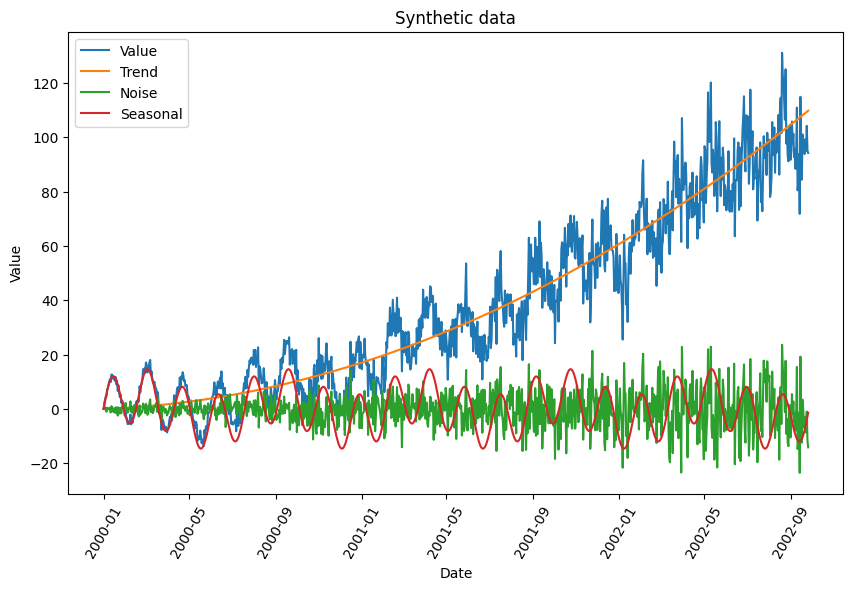

In [4]:
df_synthetic = create_data(1000)
plot_data('Synthetic data',df_synthetic)

## REAL

In [5]:
df = pd.read_csv('../Data/Beban_listrik.csv')

In [6]:
df.head()

,Date,EnergyConsumption
0,01/01/2016,2.540
1,02/01/2016,2.732
2,03/01/2016,2.712
3,04/01/2016,3.007
4,05/01/2016,2.967


In [7]:
df.columns = ['Date', 'Value']

In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [9]:
df.set_index('Date', inplace=True)

In [10]:
# Membagi DataFrame berdasarkan tahun
data_by_year = {year: df[df.index.year == year] for year in df.index.year.unique()}

In [11]:
df_all = df.copy()
df_2016 = data_by_year[2016]
df_2017 = data_by_year[2017]
df_2018 = data_by_year[2018]
df_2019 = data_by_year[2019]
df_2020 = data_by_year[2020]

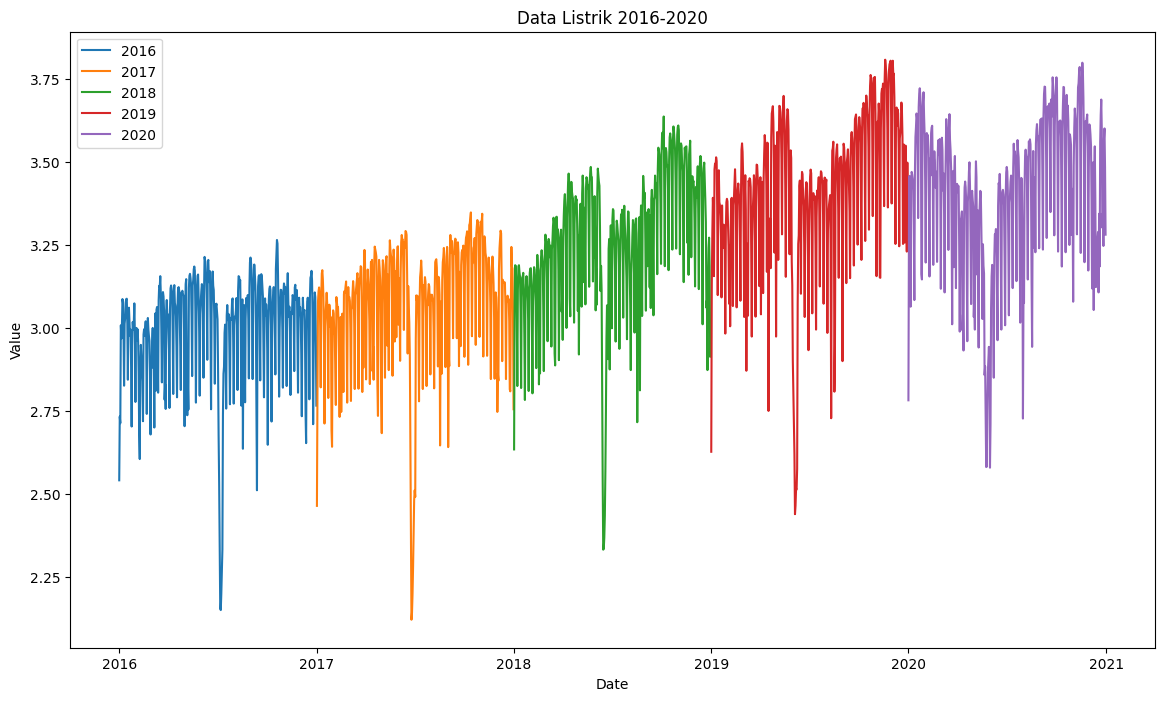

In [12]:
# Plot data listrik 6 tahun
plt.figure(figsize=(14, 8))

plt.plot(df_2016.index, df_2016['Value'], label='2016')
plt.plot(df_2017.index, df_2017['Value'], label='2017')
plt.plot(df_2018.index, df_2018['Value'], label='2018')
plt.plot(df_2019.index, df_2019['Value'], label='2019')
plt.plot(df_2020.index, df_2020['Value'], label='2020')

plt.title('Data Listrik 2016-2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

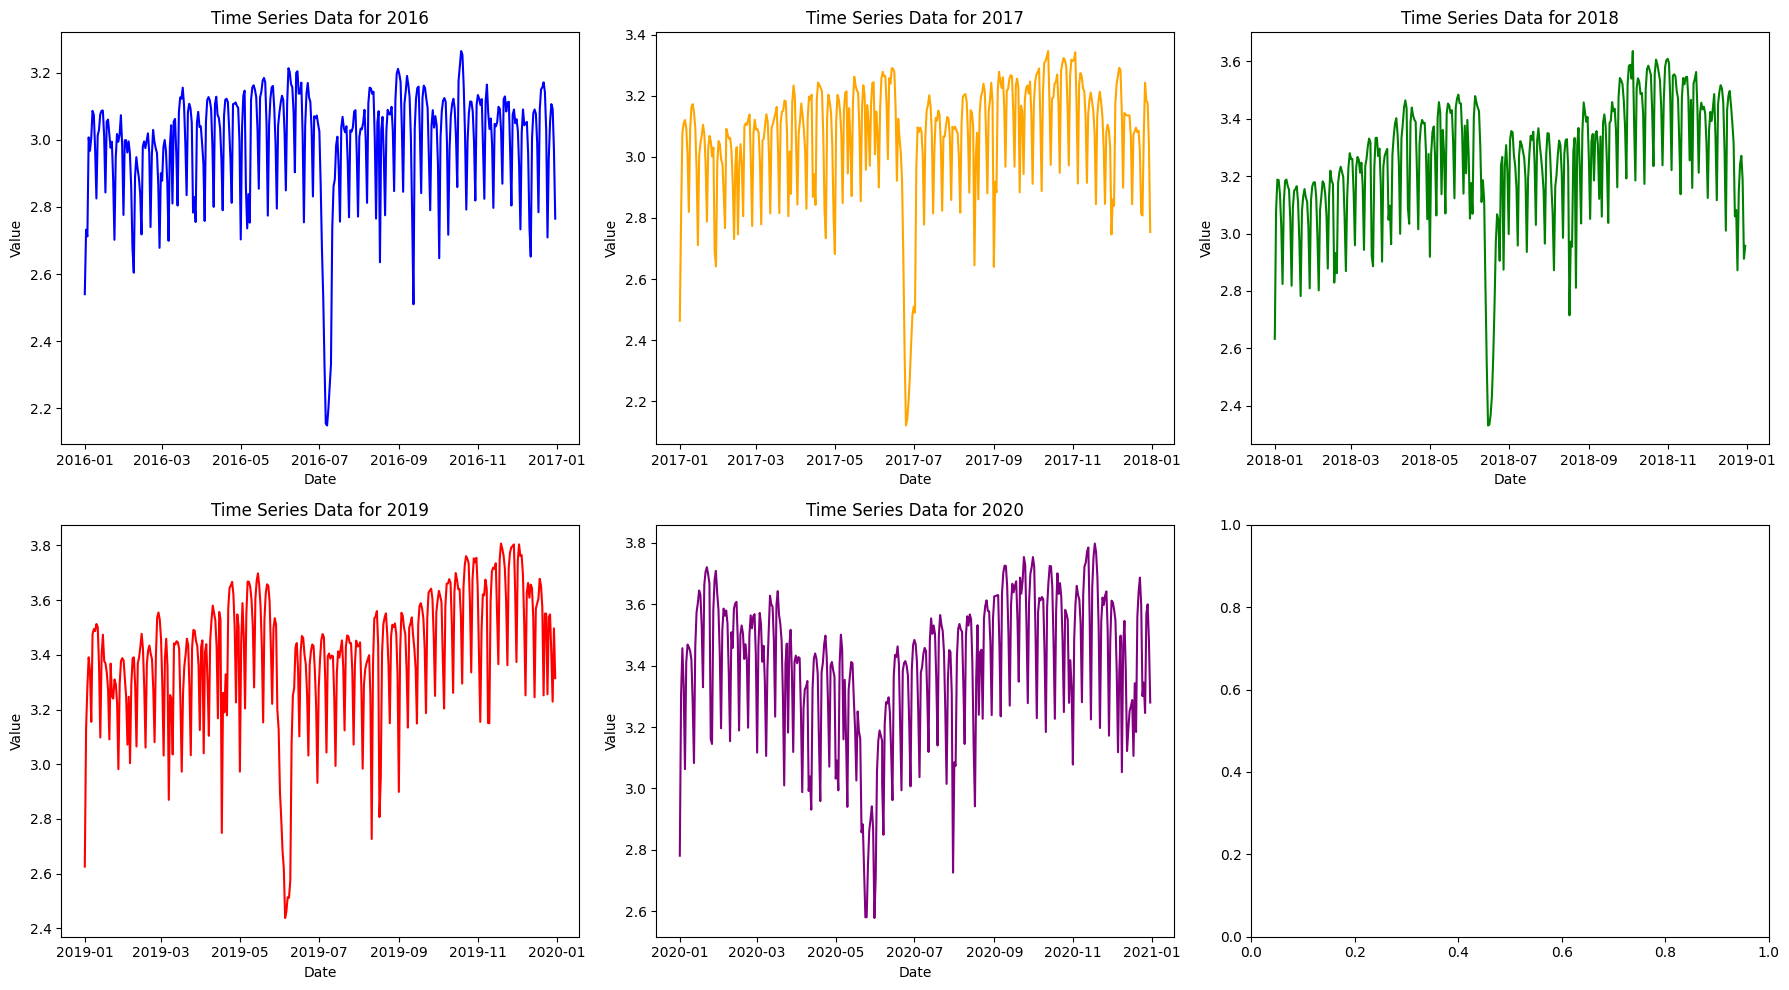

In [13]:
# Plot data listrik setiap tahun dalam subplot terpisah
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False)

colors = ['blue', 'orange', 'green', 'red', 'purple']
data_by_year_items = list(data_by_year.items())

for ax, (year, data), color in zip(axes.flat, data_by_year_items, colors):
    ax.plot(data.index, data['Value'], color=color)
    ax.set_title(f'Time Series Data for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# SSA


In [14]:
data = df_all.copy()

## WINDOWING

In [15]:
def windowing(F, L):
  N = len(F)
  K = N - L + 1
  X = np.column_stack([F[i:i+L] for i in range(0,K)])
  return X

In [16]:
X = windowing(data['Value'], 914)

## DEKOMPOSISI

In [17]:
def dekomposisi(X):
  d = np.linalg.matrix_rank(X)
  U, Sigma, V = np.linalg.svd(X)
  V = V.T
  X_komponen = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

  if not np.allclose(X, X_komponen.sum(axis=0), atol=1e-10):
      print("WARNING: The sum of X's elementary matrices is not equal to X!")

  return X_komponen, Sigma, d

In [57]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

def plot_komponen(X_komponen, d):
    d = min(d, 16)
    cols = 4
    rows = math.ceil(d / cols)
    for i in range(d):
        plt.subplot(rows, cols, i + 1)
        title = "$\mathbf{X}_{" + str(i) + "}$"
        plot_2d(X_komponen[i], title)
    plt.tight_layout()

def plot_kontribusi_komponen(Sigma, limit_x):
    sigma_sumsq = (Sigma**2).sum()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
    ax[0].set_xlim(0,limit_x)
    ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[0].set_xlabel("$i$")
    ax[0].set_ylabel("Contribution (%)")
    ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
    ax[1].set_xlim(0,limit_x)
    ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[1].set_xlabel("$i$")
    ax[1].set_ylabel("Contribution (%)");

def Hankelise(X, L):
    L, K = X.shape
    transpose = False
    if L > K:
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def plot_komponen_line(X_komponen, t):
    t = range(0,t)

    # Color cycle
    plt.figure(figsize=(100, 100))
    fig, axes = plt.subplots(5, 2)
    axes = axes.flatten()
    colors = plt.get_cmap('tab20').colors

    F_i = []
    # mengkonversi matriks elementer menjadi time series
    for i in range(0,10):
        F_i.append(X_to_TS(X_komponen[i]))
        axes[i].plot(t, F_i[i], lw=2, color=colors[i % len(colors)])
        axes[i].set_title(f"Komponen {i}")

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    return F_i

def wcorr(X_komponen, L, K, d):
    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

    # Get all the components of the toy series, store them as columns in F_elem array.
    F_elem = np.array([X_to_TS(X_komponen[i]) for i in range(d)])

    # Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
    F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
    F_wnorms = F_wnorms**-0.5

    # Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
    # and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]
    return Wcorr

In [19]:
X_komponen, Sigma, d = dekomposisi(X)

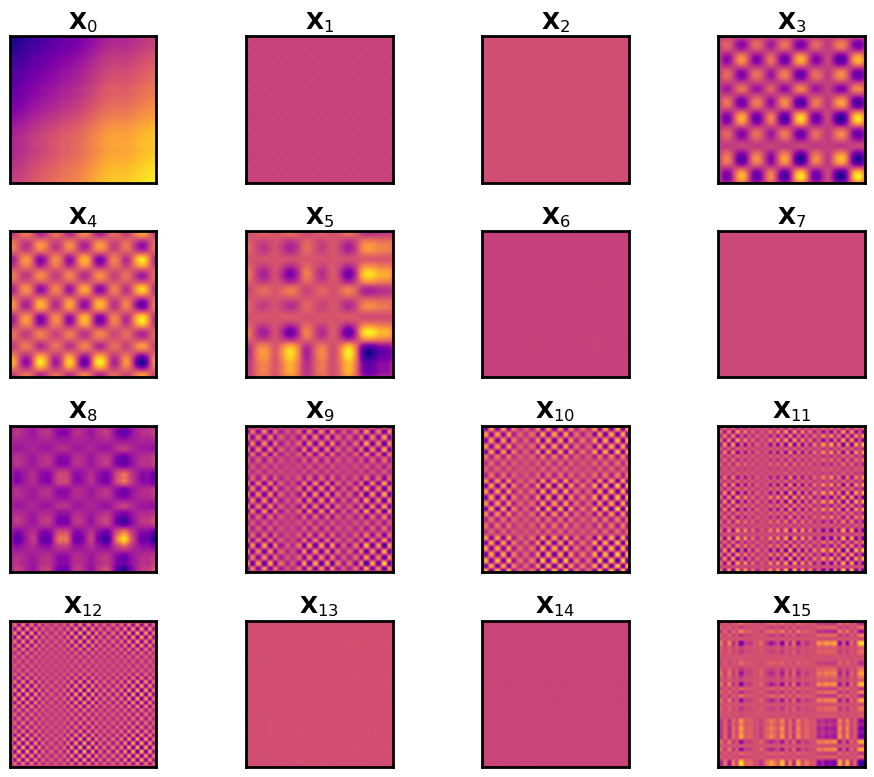

In [20]:
plot_komponen(X_komponen, d)

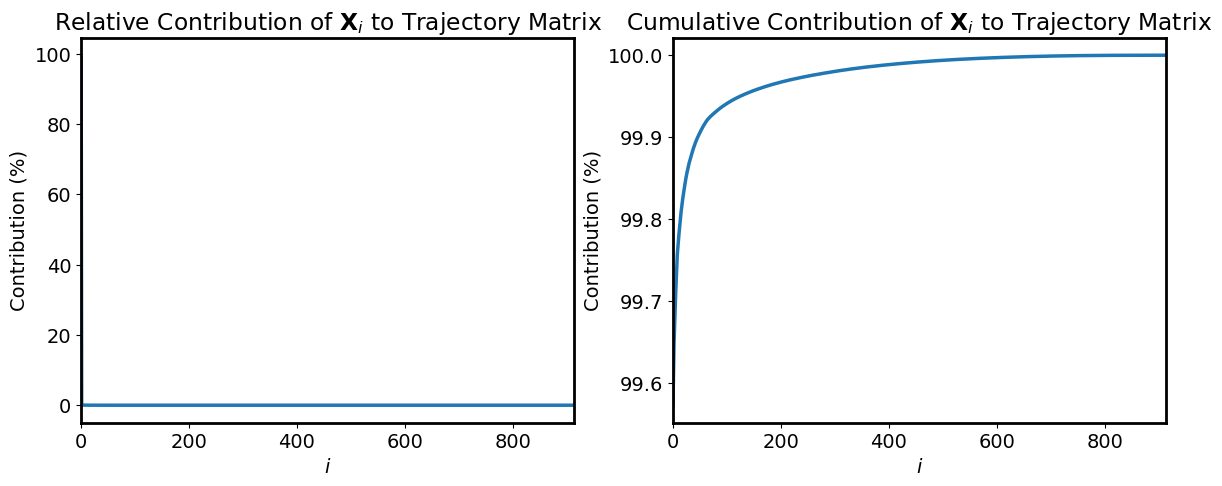

In [27]:
plot_kontribusi_komponen(Sigma, d)

<Figure size 10000x10000 with 0 Axes>

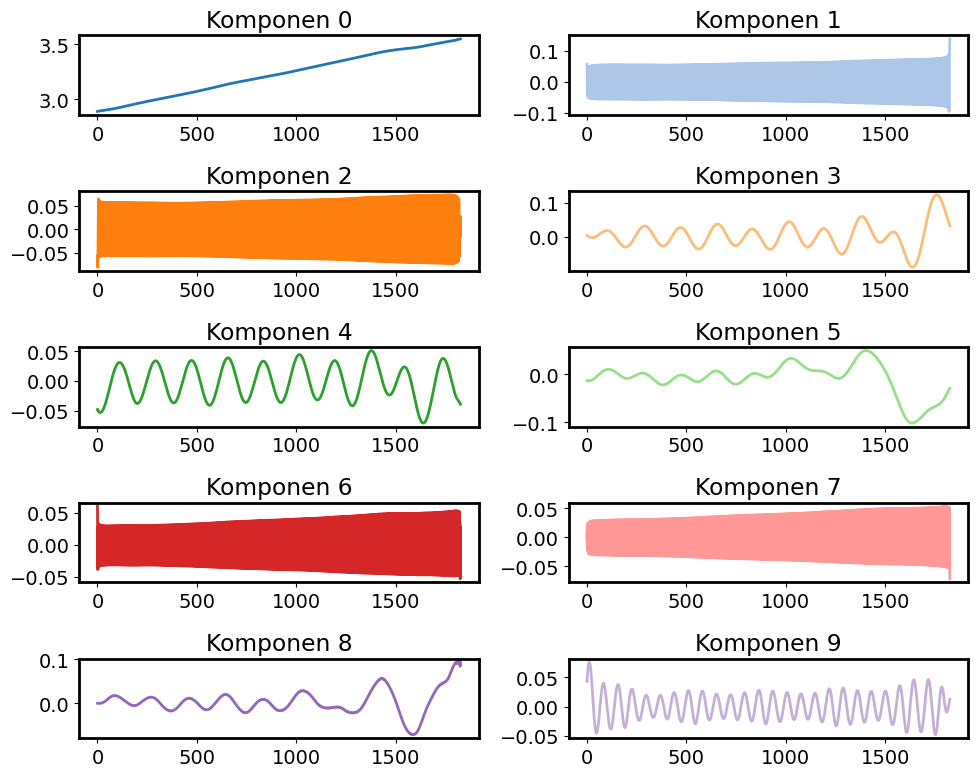

In [58]:
F_i = plot_komponen_line(X_komponen, len(data))

In [59]:
len(F_i)

10